# Try out CNN on EEG data with labels

## Pre-processing
+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.

## Train CNN network
+ Define network architecture
+ Split data
+ Train model

### Use mcfly for some first model testing: https://github.com/NLeSC/mcfly

## Import packages & links

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
#%matplotlib inline

from mayavi import mlab

In [2]:
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_ePodium\\"
PATH_CODE = ROOT + "EEG_explorer\\"
PATH_DATA = ROOT + "Data\\"
PATH_OUTPUT = ROOT + "Data\\processed\\"
PATH_METADATA = ROOT + "Data\\metadata\\"
PATH_MODELS = ROOT + "trained_models\\"
file_labels = "metadata.xlsx"

import sys
sys.path.insert(0, PATH_CODE)

## Load pre-processed dataset
+ See notebook for preprocessing: Exploring_EEG_data_04_prepare_data_for_ML.ipynb

In [3]:
filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected.npy"
signal_collection = np.load(filename)

filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_labels.npy"
label_collection = np.load(filename)

In [4]:
import csv
metadata = []
filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_metadata.csv"
with open(filename, 'r') as readFile:
    reader = csv.reader(readFile, delimiter=',')
    for row in reader:
        if len(row) > 0:
            metadata.append(row)

readFile.close()
#writeFile.close()

In [5]:
metadata[:10]

[['1', '034_17_mc_mmn36_wk.cnt', '443'],
 ['2', '036_17_mc_mmn36_wk.cnt', '1384'],
 ['18', '175_17_jd_mmn_wk.cnt', '1858'],
 ['26', '305_17_jc_mmn36_wk.cnt', '2349'],
 ['27', '306_17_mc_mmn36_wk.cnt', '2813'],
 ['28', '307_17_jc_mmn36_wakker.cnt', '3447'],
 ['29', '308_17_jc_mmn36_wk.cnt', '3938'],
 ['30', '309_17_jc_mmn.cnt', '4425'],
 ['33', '314_17_mc_mmn36_wk.cnt', '4917'],
 ['38', '337_17_jc_mmn36_wk.cnt', '5389']]

## Split training data
The entire dataset is split into:
+ training data (here: about 70%) which is used to train a model.
+ validation data, used to monitor the model progress and avoid overfitting.
+ testing data, meant for final check on model performance.

#### Scale/normalize data

In [6]:
signal_collection.shape, int(metadata[0][2])

((39083, 30, 501), 443)

In [7]:
min_maxes = []
for ID in range(1,len(metadata)):
    min_maxes.append((signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].min(), 
                     signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].max(), 
                     signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].mean(), 
                     signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].var()))

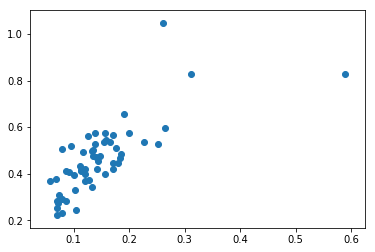

In [8]:
plt.scatter([np.round(100000000*x[3],8) for x in min_maxes], [np.round(1000*x[1],8) for x in min_maxes])

(array([ 2.,  3.,  3.,  6.,  8.,  9., 11.,  6.,  6.,  2.]),
 array([-2.870e-06, -2.299e-06, -1.728e-06, -1.157e-06, -5.860e-07,
        -1.500e-08,  5.560e-07,  1.127e-06,  1.698e-06,  2.269e-06,
         2.840e-06]),
 <a list of 10 Patch objects>)

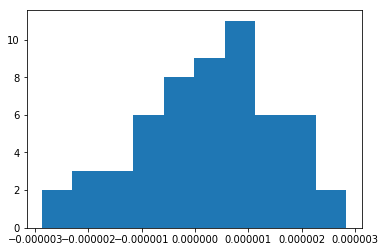

In [9]:
plt.hist([np.round(x[2],8) for x in min_maxes])

(array([10.,  7., 13., 10.,  8.,  2.,  1.,  3.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([5.75752387e-10, 8.41246397e-10, 1.10674041e-09, 1.37223442e-09,
        1.63772843e-09, 1.90322244e-09, 2.16871644e-09, 2.43421045e-09,
        2.69970446e-09, 2.96519847e-09, 3.23069248e-09, 3.49618649e-09,
        3.76168050e-09, 4.02717451e-09, 4.29266852e-09, 4.55816253e-09,
        4.82365654e-09, 5.08915055e-09, 5.35464456e-09, 5.62013857e-09,
        5.88563258e-09]),
 <a list of 20 Patch objects>)

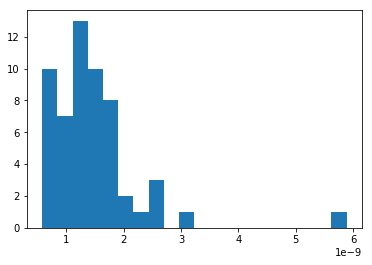

In [10]:
plt.hist([x[3] for x in min_maxes], 20)
#[x[3] for x in min_maxes]

In [11]:
# mean of all max and min:
print("Mean of all min: ", np.mean([x[0] for x in min_maxes]))
print("Mean of all max: ", np.mean([x[1] for x in min_maxes]))
print("Mean of all mean: ", np.mean([x[2] for x in min_maxes]))

Mean of all min:  -0.00044156463409497675
Mean of all max:  0.0004616334911644572
Mean of all mean:  2.984203915534805e-07


In [12]:
signal_collection.mean()

2.5096784909529265e-07

In [13]:
data_max = np.mean([x[1] for x in min_maxes]) #signal_collection.max()
data_min = np.mean([x[0] for x in min_maxes]) #signal_collection.min()
data_mean = signal_collection.mean()

signal_collection = signal_collection - data_mean
signal_collection = signal_collection / data_max

In [14]:
signal_collection.min(), signal_collection.max()

(-1.9539306399697487, 2.2628056343165652)

In [15]:
label_collection[:10]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

### Split into training, validation, and test sets

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(signal_collection, label_collection, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

In [17]:
print('Train set size:', X_train.shape[0])
print('Validation set size:', X_val.shape[0])
print('Test set size:', X_test.shape[0])
print()
print("X_train mean, min, max: ", np.mean(X_train), np.min(X_train), np.max(X_train))

Train set size: 28237
Validation set size: 4983
Test set size: 5863

X_train mean, min, max:  0.0002733286551441125 -1.6984239738598144 2.2628056343165652


In [65]:
def plot_epoch_selection(X_data, IDs, ID_channel, n_x):
    """ Plot different epochs to give overview picture..."""
    
    # These are the colors that will be used in the plot
    color_sequence = ['#003f5c','#882556', '#D65113', '#ffa600', '#58508d', '#bc5090', 
                      '#2651d1', '#2f4b7c', '#ff6361', '#a05195', '#d45087'] 
                      
    #fig, ax = plt.subplots(figsize=(10,16))
    #plt.subplot(211)
    n_y = np.ceil(len(IDs) / n_x)
    
    fig = plt.figure(figsize=(10,10))
    for i, ID in enumerate(IDs):
        ax = fig.add_subplot(n_y, n_x, i+1)
        for ID_ch in ID_channel:
            ax.plot(np.linspace(-0.2, 0.8, 501), X_data[ID, ID_ch, :],
                 linewidth=1, color=color_sequence[0], alpha=0.5)
        
    plt.xlabel('Time [s]')
    plt.ylabel('Signal intensity (normalized)')

In [71]:
np.where((y_train == 3))[0][:10]

array([ 0,  3, 14, 18, 19, 21, 22, 25, 27, 31], dtype=int64)

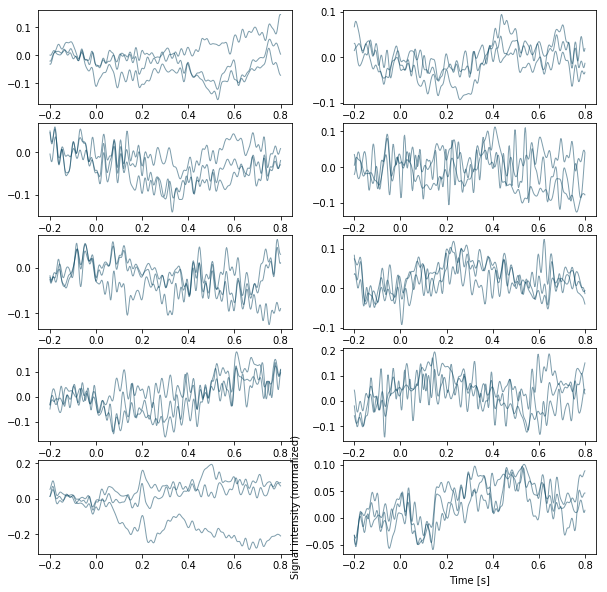

In [69]:
select = np.where((y_train == 3))[0]

plot_epoch_selection(X_train, [x for x in select[:10]], [9, 10, 11], 2)
plt.savefig('epoch examples_01.pdf')

In [79]:
signal_collection.shape, label_collection.shape

((39083, 30, 501), (39083,))

In [80]:
label_collection[:10]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

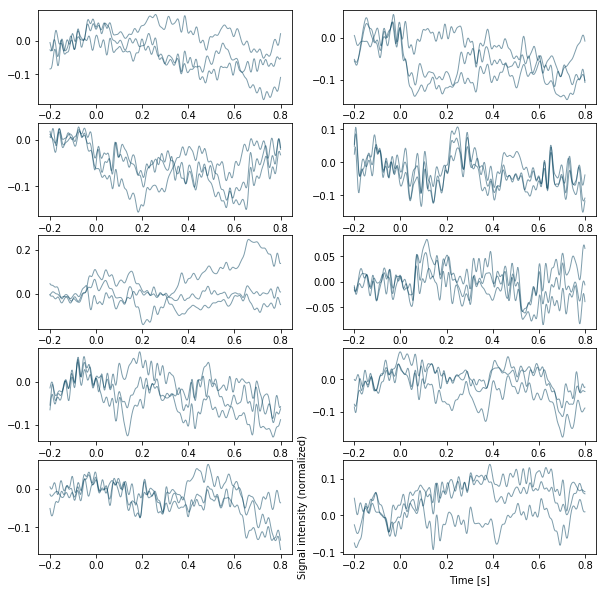

In [89]:
select = np.where((label_collection == 13))[0]

#plot_epoch_selection(X_train, [x for x in select[:10]], [9, 10, 11], 2)
plot_epoch_selection(signal_collection, [x for x in select[-10:]], [9, 10, 11], 2)
plt.savefig('epoch examples_13_2.pdf')

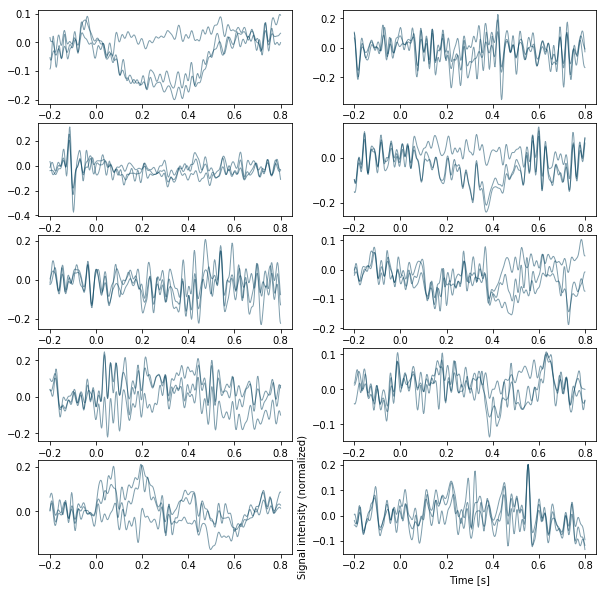

In [90]:
select = np.where((label_collection == 26))[0]

#plot_epoch_selection(X_train, [x for x in select[:10]], [9, 10, 11], 2)
plot_epoch_selection(signal_collection, [x for x in select[10:20]], [9, 10, 11], 2)
plt.savefig('epoch examples_26.pdf')

## Switch to 1-hot encoding for labels
+ We have six categories or classes. Those are best represented by a so called 1-hot encoding. This means nothing else than simply a binary 0-or-1 for every class.. 

In [91]:
from sklearn.preprocessing import LabelBinarizer
label_transform = LabelBinarizer()

y_train_binary = label_transform.fit_transform(y_train.astype(int))
y_val_binary = label_transform.fit_transform(y_val.astype(int))
y_test_binary = label_transform.fit_transform(y_test.astype(int))

In [92]:
y_val_binary[:10,:]

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [93]:
# Show found labels:
label_transform.classes_

array([  3,   6,  13,  26,  66, 132])

Check distribution accross the 6 label categories:

In [94]:
labels = list(label_transform.classes_)
frequencies = y_train_binary.mean(axis=0)
frequencies_df = pd.DataFrame(frequencies, index=labels, columns=['frequency'])
frequencies_df

,frequency
3,0.313206
6,0.488437
13,0.038885
26,0.061515
66,0.038141
132,0.059815


### Note:
We have more data on group 2 than on group 1. And far more data for stimuli 3 than for stimuli 13 and 66 (not surprising). 

--> post on balancing datasets: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

### Needs some thinking on how to balance the data set !
e.g. by frequency dependend selection rule, or by defining a suitied special loss function....

In [95]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [96]:
class_weight

array([0.53213101, 0.34122438, 4.28612629, 2.70936481, 4.36969978,
       2.78636274])

In [97]:
class_weight = {0: class_weight[0],
               1: class_weight[1],
               2: class_weight[2],
               3: class_weight[3],
               4: class_weight[4],
               5: class_weight[5]}

## Define model architecture

In [98]:
import tensorflow as tf
from tensorflow.keras import layers

In [20]:
# Model test 1
n_timesteps = 501
n_features = 30
n_outputs = 6

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [99]:
# Simple CNN model
n_timesteps = 501
n_features = 30
n_outputs = 6

model = tf.keras.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=20, input_shape=(n_timesteps,n_features)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=64, kernel_size=5)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

#model.add(layers.Conv1D(filters=96, kernel_size=3, activation='relu'))
#model.add(layers.AveragePooling1D(pool_size=2))
#model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_outputs, activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [100]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 482, 32)           19232     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 482, 32)           128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 482, 32)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 241, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 232, 64)           20544     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 232, 64)           256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 232, 64)           0         
__________

In [102]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
output_file = 'CNN_EEG_classifier01'

checkpointer = ModelCheckpoint(filepath = PATH_MODELS + output_file + ".hdf5", monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

In [103]:
epochs = 50
batch_size = 32

# fit network
model.fit(np.swapaxes(X_train,1,2), y_train_binary, 
          validation_data=(np.swapaxes(X_val,1,2), y_val_binary), 
          epochs=epochs, 
          batch_size=batch_size,
          class_weight = class_weight,
          callbacks = [checkpointer, earlystopper])

Train on 28237 samples, validate on 4983 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
28224/28237 [============================>.] - ETA: 0s - loss: 1.8521 - acc: 0.1186- ETA: 3s - loss: 1
Epoch 00001: val_acc improved from -inf to 0.14871, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_classifier01.hdf5
28237/28237 [==============================] - 148s 5ms/sample - loss: 1.8520 - acc: 0.1185 - val_loss: 1.7617 - val_acc: 0.1487
Epoch 2/50
28224/28237 [============================>.] - ETA: 0s - loss: 1.8208 - acc: 0.2757
Epoch 00002: val_acc improved from 0.14871 to 0.45274, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_classifier01.hdf5
28237/28237 [==============================] - 153s 5ms/sample - loss: 1.8208 - acc: 0.2758 - val_loss: 1.7731 - val_acc: 0.4527
Epoch 3/50
28224/28237 [============================>.] - ETA: 0s - loss: 1.8125 - acc: 0.3717
Epoc

## Plotting function

In [104]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    ## Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Not (yet) working...

In [105]:
# evaluate the model
#_, train_acc = model.evaluate(np.swapaxes(X_train,1,2), y_train_binary, verbose=0)
_, test_acc = model.evaluate(np.swapaxes(X_test,1,2), y_test_binary, verbose=0)

In [106]:
print(test_acc)

0.46409687


In [107]:
Xtest = np.swapaxes(X_test,1,2)

# check model predictions:
y_pred_proba = model.predict_proba(Xtest)
y_pred_classes = model.predict_classes(Xtest)

In [108]:
y_test_05 = np.array(y_test.copy())
y_test_05[y_test_05 == 3] = 0
y_test_05[y_test_05 == 6] = 1
y_test_05[y_test_05 == 13] = 2
y_test_05[y_test_05 == 26] = 3
y_test_05[y_test_05 == 66] = 4
y_test_05[y_test_05 == 132] = 5

print(y_test_05[:30].astype(int))
print(y_pred_classes[:30])

[0 0 0 1 3 1 4 1 1 0 0 1 0 1 1 1 3 0 1 1 1 1 1 0 0 4 0 1 4 0]
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]


In [109]:
# Calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test_05, y_pred_classes))

0.46409687873102506


In [110]:
# Confusion matrix:
M_confusion = metrics.confusion_matrix(y_test_05, y_pred_classes)
M_confusion

array([[ 356, 1528,    0,    2,    1,    1],
       [ 421, 2365,    0,    0,    0,    0],
       [  41,  204,    0,    0,    0,    0],
       [  45,  296,    0,    0,    0,    0],
       [  43,  193,    0,    0,    0,    1],
       [  55,  311,    0,    0,    0,    0]], dtype=int64)

Normalized confusion matrix
[[1.88559322e-01 8.09322034e-01 0.00000000e+00 1.05932203e-03
  5.29661017e-04 5.29661017e-04]
 [1.51112706e-01 8.48887294e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.67346939e-01 8.32653061e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.31964809e-01 8.68035191e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.81434599e-01 8.14345992e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.21940928e-03]
 [1.50273224e-01 8.49726776e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


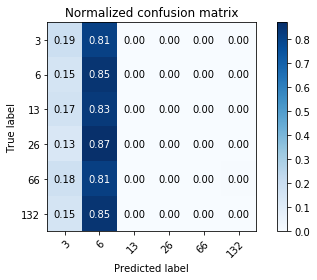

In [111]:
# Plot normalized confusion matrix
labels = list(label_transform.classes_)

plot_confusion_matrix(y_test_05, y_pred_classes, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix_nonaveraged.pdf')

## Check if groups are predicted correctly

In [112]:
y_test_12 = np.array(y_test.copy())
y_test_12[y_test_12 == 132] = 2
y_test_12[y_test_12 == 66] = 1
y_test_12[y_test_12 == 26] = 2
y_test_12[y_test_12 == 13] = 1
y_test_12[y_test_12 == 6] = 2
y_test_12[y_test_12 == 3] = 1

y_pred_12 = y_pred_classes.copy()
y_pred_12[(y_pred_12 == 4) | (y_pred_12 == 2) | (y_pred_12 == 0)] = 6
y_pred_12[(y_pred_12 == 5) | (y_pred_12 == 3) | (y_pred_12 == 1)] = 2
y_pred_12[y_pred_12 == 6] = 1

print(y_test_12[:30].astype(int))
print(y_pred_12[:30])

[1 1 1 2 2 2 1 2 2 1 1 2 1 2 2 2 2 1 2 2 2 2 2 1 1 1 1 2 1 1]
[2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2]


In [113]:
np.sum(y_test_12 == y_pred_12)/ y_pred_12.shape[0]

0.5821251918812894

# TO be continued...
+ Try with only 1 binary label --> Risk group vs Not-risk group
+ Test LSTM
+ Work with higher compression --> more pooling in the beginning ?

# 2. Reduce categories:
One problem might arise from that fact that we don't know the stimuli!  
Very likely either "13 or "66" means that same as "3" and hence CANNOT be distinguishes by the model...  
Here I would like to explore a bit what happens if we only look at 2 categories instead of 6.

## Switch to 1-hot encoding for labels
+ We have six categories or classes. Those are best represented by a so called 1-hot encoding. This means nothing else than simply a binary 0-or-1 for every class.. 